In [120]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
import xarray as xr
from tensorflow.keras import models, layers, regularizers,optimizers
# from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import to_categorical
from scipy.io import savemat
import h5py
import matplotlib.pyplot as plt
import pygmt
from sklearn.model_selection import train_test_split

## Load Data

In [208]:
ship_depth=pygmt.grdtrack(points="../data/guinea.txt",grid="../data/gebco.nc",no_skip=True)
ship_depth[3]=ship_depth[2]-ship_depth[3]
pygmt.info(data=ship_depth)

'<vector memory>: N = 118280 <-14.99975/4.9997> <-4/4> <-5944/-80.2> <-1431.29066483/4855.4328125>\n'

In [209]:
ship_depth=ship_depth[abs(ship_depth[3])<500]
pygmt.info(data=ship_depth)


'<vector memory>: N = 113004 <-14.99975/4.9997> <-4/4> <-5591/-393.7> <-99.96922809/99.9936505>\n'

In [210]:
ship_depth=ship_depth.drop(3,axis = 1)  # 删除第0列，

In [211]:
pygmt.info(data="../data/guinea.txtok")

'../data/guinea.txtok: N = 117814 <-14.99975/4.9997> <-4/4> <-5626.6/-297.5>\n'

In [212]:
# control
reg="-15.5/5.5/-4.5/4.5"
# ../data/guinea.txtok is the clean data with abs bais larger than 500 excluded.
control0=pygmt.select(region="free2.grd",data=ship_depth)
control, check = train_test_split(control0, train_size=0.8, test_size=0.2, random_state=17)

free = pygmt.grdcut(grid="../GeoModel/Free_Air_Gravity_Anomalies/Free_Air_Gravity_Anomalies.nc", region="-15.5/5.5/-4.5/4.5")
free.to_netcdf("free2.grd")

vgg = pygmt.grdcut(grid="../GeoModel/Vertical_Gravity_Gradient/Vertical_Gravity_Gradient.nc", region="-15.5/5.5/-4.5/4.5")
vgg_1m=pygmt.grd2xyz(grid=vgg)
pygmt.surface(region=reg, spacing="1m",outgrid="vgg.grd",data=vgg_1m)


nvd = pygmt.grdcut(grid="../data/north_32.1.nc", region="-15.5/5.5/-4.5/4.5")
nvd_1m = pygmt.grdsample(grid=nvd, spacing="1m")
nvd_1m=pygmt.grd2xyz(grid=nvd)
pygmt.surface(region=reg, spacing="1m",outgrid="nvd.grd",data=nvd_1m)

evd = pygmt.grdcut(grid="../data/east_32.1.nc", region="-15.5/5.5/-4.5/4.5")
evd_1m=pygmt.grd2xyz(grid=evd)
pygmt.surface(region=reg, spacing="1m",outgrid="evd.grd",data=evd_1m)

sed = pygmt.grdcut(grid="../data/sed.nc", region="-15.5/5.5/-4.5/4.5")
sed_1m=pygmt.grd2xyz(grid=sed)
pygmt.surface(region=reg, spacing="1m",outgrid="sed.grd",data=sed_1m)

age = pygmt.grdcut(grid="../data/age.nc", region="-15.5/5.5/-4.5/4.5")
age_1m=pygmt.grd2xyz(grid=age)
pygmt.surface(region=reg, spacing="1m",outgrid="age.grd",data=age_1m)

moho = pygmt.grdcut(grid="../data/moho.nc", region="-15.5/5.5/-4.5/4.5")
moho_1m=pygmt.grd2xyz(grid=moho)
pygmt.surface(region=reg, spacing="1m",outgrid="moho.grd",data=moho_1m)

mag = pygmt.grdcut(grid="../data/mag.nc", region="-15.5/5.5/-4.5/4.5")
mag_1m=pygmt.grd2xyz(grid=mag)
pygmt.surface(region=reg, spacing="1m",outgrid="mag.grd",data=mag_1m)

surface [WARNING]: 376799 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.
surface [WARNING]: 376799 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


In [213]:
check.shape

(22601, 3)

In [214]:
control.shape

(90403, 3)

## process data

### short g for control

In [215]:
control_depth_free=pygmt.grdtrack(points=control.values,grid="free2.grd",no_skip=True)
y_train1 = control_depth_free.values[:,0:3] # lon lat depth
x_train1 = control_depth_free.values[:,3] # gravity
x_train1 = np.reshape(x_train1, (len(x_train1), 1))

x_lat = np.reshape(y_train1[:, 1], (len(y_train1[:, 1]), 1))
x_lon = np.reshape(y_train1[:, 0], (len(y_train1[:, 0]), 1))

rou=1.0
d=-8000
control_short=(y_train1[:,2]-d)*2*3.1415*6.67259*(10**-8)*rou*100000 # short wavelength gravity ano
control_short = np.reshape(control_short, (len(control_short), 1))
control_long=x_train1-control_short
short=np.concatenate((y_train1[:,0:2],control_short),axis=1)
long=np.concatenate((y_train1[:,0:2],control_long),axis=1)
reg="-15.5/5.5/-4.5/4.5"

long_bmean = pygmt.blockmean(data=long, region=reg, spacing="1m")
pygmt.surface(region=reg, spacing="1m",outgrid="long.grd",data=long_bmean)
temp=pygmt.grd2xyz(grid="free2.grd")
temp_bmean = pygmt.blockmean(data=temp, region=reg, spacing="1m")
pygmt.surface(region=reg, spacing="1m",outgrid="free3.grd",data=temp_bmean)

long0 = xr.open_dataset("long.grd")
free0 = xr.open_dataset("free3.grd")
short0 = free0-long0
short0.to_netcdf("short.grd")

surface [WARNING]: 5 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


In [220]:
# ship_bmean = pygmt.blockmean(data=control, region=reg, spacing="1m")
# ship_grid=pygmt.surface(region=reg, spacing="1m",data=ship_bmean)
# ship_grid.plot()

In [221]:
# short0.z.plot()

In [129]:
# for test


### portfolios for train

In [130]:
control_ga = pygmt.grdtrack(points=control.values,grid="free3.grd",no_skip=True)
control_ga = np.reshape(control_ga.values[:,3],(len(control_ga.values[:,0]),1))

control_vgg = pygmt.grdtrack(points=control.values,grid="vgg.grd",no_skip=True)
control_vgg = np.reshape(control_vgg.values[:,3],(len(control_vgg.values[:,0]),1))

control_evd = pygmt.grdtrack(points=control.values,grid="evd.grd",no_skip=True)
control_evd = np.reshape(control_evd.values[:,3],(len(control_evd.values[:,0]),1))

control_nvd = pygmt.grdtrack(points=control.values,grid="nvd.grd",no_skip=True)
control_nvd = np.reshape(control_nvd.values[:,3],(len(control_nvd.values[:,0]),1))

control_sed = pygmt.grdtrack(points=control.values,grid="sed.grd",no_skip=True)
control_sed = np.reshape(control_sed.values[:,3],(len(control_sed.values[:,0]),1))

control_age = pygmt.grdtrack(points=control.values,grid="age.grd",no_skip=True)
control_age = np.reshape(control_age.values[:,3],(len(control_age.values[:,0]),1))

control_moho = pygmt.grdtrack(points=control.values,grid="moho.grd",no_skip=True)
control_moho = np.reshape(control_moho.values[:,3],(len(control_moho.values[:,0]),1))

control_mag = pygmt.grdtrack(points=control.values,grid="mag.grd",no_skip=True)
control_mag = np.reshape(control_mag.values[:,3],(len(control_mag.values[:,0]),1))


In [131]:
# normalization
y_train2 = np.reshape(y_train1[:, 2], (len(y_train1[:, 2]), 1)) # depth

scalerlon = MinMaxScaler().fit(x_lon)
scalerlat = MinMaxScaler().fit(x_lat)
scalershort = MinMaxScaler().fit(control_short)
scalerga = MinMaxScaler().fit(control_ga)
scalervgg = MinMaxScaler().fit(control_vgg)
scalerevd = MinMaxScaler().fit(control_evd)
scalernvd = MinMaxScaler().fit(control_nvd)
scalersed = MinMaxScaler().fit(control_sed)
scalerage = MinMaxScaler().fit(control_age)
scalermoho = MinMaxScaler().fit(control_moho)
scalermag = MinMaxScaler().fit(control_mag)
scalerytrain = MinMaxScaler().fit(y_train2)

lat_train = scalerlat.transform(x_lat)
lon_train = scalerlon.transform(x_lon)
short_train = scalershort.transform(control_short)
ga_train = scalerga.transform(control_ga)
vgg_train = scalervgg.transform(control_vgg)
evd_train = scalerevd.transform(control_evd)
nvd_train = scalernvd.transform(control_nvd)
sed_train = scalersed.transform(control_sed)
age_train = scalerage.transform(control_age)
moho_train = scalermoho.transform(control_moho)
mag_train = scalermag.transform(control_mag)
y_trian = scalerytrain.transform(y_train2)

In [132]:
# case1 LON LAT GA VGG EVD NVD  6
train_case1 =  np.concatenate((lon_train, lat_train, ga_train,vgg_train,evd_train,nvd_train), axis=1)

In [133]:
# case2 LON LAT SG 3
train_case2 =  np.concatenate((lon_train, lat_train, short_train), axis=1)

In [134]:
# case3 LON LAT SG VGG EVD NVD 6
train_case3 =  np.concatenate((lon_train, lat_train, short_train,vgg_train,evd_train,nvd_train), axis=1)

In [135]:
# case4 LON LAT SG MA AGE 5
train_case4 =  np.concatenate((lon_train, lat_train,short_train,sed_train,age_train), axis=1)

In [136]:
# case5 LON LAT SG MA AGE ST DM 7
train_case5 =  np.concatenate((lon_train, lat_train,short_train,sed_train,age_train,moho_train,mag_train), axis=1)

In [137]:
# case6 LON LAT SG VGG EVD NVD MA AGE ST DM 10
train_case6 =  np.concatenate((lon_train, lat_train,short_train,vgg_train,evd_train,nvd_train,sed_train,age_train,moho_train,mag_train), axis=1)

In [138]:
# case1.1 LON LAT GA VGG EVD NVD MA AGE 8
train_case1_1 =  np.concatenate((lon_train, lat_train,ga_train,vgg_train,evd_train,nvd_train,sed_train,age_train), axis=1)

### portfolios for test

In [139]:
check_lon = np.reshape(check.values[:,0],(len(check.values[:,0]),1))

check_lat = np.reshape(check.values[:,1],(len(check.values[:,0]),1))

y_test1 = np.reshape(check.values[:,2],(len(check.values[:,0]),1))

check_short = pygmt.grdtrack(points=check.values,grid="short.grd",no_skip=True)
check_short = np.reshape(check_short.values[:,3],(len(check_short.values[:,0]),1))

check_ga = pygmt.grdtrack(points=check.values,grid="free3.grd",no_skip=True)
check_ga = np.reshape(check_ga.values[:,3],(len(check_ga.values[:,0]),1))

check_vgg = pygmt.grdtrack(points=check.values,grid="vgg.grd",no_skip=True)
check_vgg = np.reshape(check_vgg.values[:,3],(len(check_vgg.values[:,0]),1))

check_evd = pygmt.grdtrack(points=check.values,grid="evd.grd",no_skip=True)
check_evd = np.reshape(check_evd.values[:,3],(len(check_evd.values[:,0]),1))

check_nvd = pygmt.grdtrack(points=check.values,grid="nvd.grd",no_skip=True)
check_nvd = np.reshape(check_nvd.values[:,3],(len(check_nvd.values[:,0]),1))

check_sed = pygmt.grdtrack(points=check.values,grid="sed.grd",no_skip=True)
check_sed = np.reshape(check_sed.values[:,3],(len(check_sed.values[:,0]),1))

check_age = pygmt.grdtrack(points=check.values,grid="age.grd",no_skip=True)
check_age = np.reshape(check_age.values[:,3],(len(check_age.values[:,0]),1))

check_moho = pygmt.grdtrack(points=check.values,grid="moho.grd",no_skip=True)
check_moho = np.reshape(check_moho.values[:,3],(len(check_moho.values[:,0]),1))

check_mag = pygmt.grdtrack(points=check.values,grid="mag.grd",no_skip=True)
check_mag = np.reshape(check_mag.values[:,3],(len(check_mag.values[:,0]),1))

In [140]:
lat_test = scalerlat.transform(check_lat)
lon_test = scalerlon.transform(check_lon)
short_test = scalershort.transform(check_short)
ga_test = scalerga.transform(check_ga)
vgg_test = scalervgg.transform(check_vgg)
evd_test = scalerevd.transform(check_evd)
nvd_test = scalernvd.transform(check_nvd)
sed_test = scalersed.transform(check_sed)
age_test = scalerage.transform(check_age)
moho_test = scalermoho.transform(check_moho)
mag_test = scalermag.transform(check_mag)
y_test = scalerytrain.transform(y_test1)

In [141]:
# case1 LON LAT GA VGG EVD NVD  6
test_case1 =  np.concatenate((lon_test, lat_test, ga_test,vgg_test,evd_test,nvd_test), axis=1)

In [142]:
# case2 LON LAT SG 3
test_case2 =  np.concatenate((lon_test, lat_test, short_test), axis=1)

In [143]:
# case3 LON LAT SG VGG EVD NVD 6
test_case3 =  np.concatenate((lon_test, lat_test, short_test,vgg_test,evd_test,nvd_test), axis=1)

In [144]:
# case4 LON LAT SG MA AGE 5
test_case4 =  np.concatenate((lon_test, lat_test,short_test,sed_test,age_test), axis=1)

In [145]:
# case5 LON LAT SG MA AGE ST DM 7
test_case5 =  np.concatenate((lon_test, lat_test,short_test,sed_test,age_test,moho_test,mag_test), axis=1)

In [146]:
# case6 LON LAT SG VGG EVD NVD MA AGE ST DM 10
test_case6 =  np.concatenate((lon_test, lat_test,short_test,vgg_test,evd_test,nvd_test,sed_test,age_test,moho_test,mag_test), axis=1)

In [147]:
# case1.1 LON LAT GA VGG EVD NVD MA AGE 8
test_case1_1 = np.concatenate((lon_test, lat_test,ga_test,vgg_test,evd_test,nvd_test,sed_test,age_test), axis=1)

### portfolios for pre

In [148]:
free_short=pygmt.grd2xyz(grid="short.grd")

pre_lon = np.reshape(free_short.values[:,0],(len(free_short.values[:,0]),1))
pre_lat = np.reshape(free_short.values[:,1],(len(free_short.values[:,0]),1))
pre_short = np.reshape(free_short.values[:,2],(len(free_short.values[:,0]),1))

free_ga=pygmt.grd2xyz(grid="free3.grd")
pre_ga = np.reshape(free_ga.values[:,2],(len(free_ga.values[:,0]),1))

free_vgg=pygmt.grd2xyz(grid="vgg.grd")
pre_vgg = np.reshape(free_vgg.values[:,2],(len(free_vgg.values[:,0]),1))

free_evd=pygmt.grd2xyz(grid="evd.grd")
pre_evd = np.reshape(free_evd.values[:,2],(len(free_evd.values[:,0]),1))

free_nvd=pygmt.grd2xyz(grid="nvd.grd")
pre_nvd = np.reshape(free_nvd.values[:,2],(len(free_nvd.values[:,0]),1))

free_sed=pygmt.grd2xyz(grid="sed.grd")
pre_sed = np.reshape(free_sed.values[:,2],(len(free_sed.values[:,0]),1))

free_age=pygmt.grd2xyz(grid="age.grd")
pre_age = np.reshape(free_age.values[:,2],(len(free_age.values[:,0]),1))

free_moho=pygmt.grd2xyz(grid="moho.grd")
pre_moho = np.reshape(free_moho.values[:,2],(len(free_moho.values[:,0]),1))

free_mag=pygmt.grd2xyz(grid="mag.grd")
pre_mag = np.reshape(free_mag.values[:,2],(len(free_mag.values[:,0]),1))

In [149]:
lat_pre = scalerlat.transform(pre_lat)
lon_pre = scalerlon.transform(pre_lon)
short_pre = scalershort.transform(pre_short)
ga_pre = scalerga.transform(pre_ga)
vgg_pre = scalervgg.transform(pre_vgg)
evd_pre = scalerevd.transform(pre_evd)
nvd_pre = scalernvd.transform(pre_nvd)
sed_pre = scalersed.transform(pre_sed)
age_pre = scalerage.transform(pre_age)
moho_pre = scalermoho.transform(pre_moho)
mag_pre = scalermag.transform(pre_mag)


In [150]:
# case1 LON LAT GA VGG EVD NVD  6
pre_case1 =  np.concatenate((lon_pre, lat_pre, ga_pre,vgg_pre,evd_pre,nvd_pre), axis=1)

In [151]:
# case2 LON LAT SG 3
pre_case2 =  np.concatenate((lon_pre, lat_pre, short_pre), axis=1)

In [152]:
# case3 LON LAT SG VGG EVD NVD 6
pre_case3 =  np.concatenate((lon_pre, lat_pre, short_pre,vgg_pre,evd_pre,nvd_pre), axis=1)

In [153]:
# case4 LON LAT SG MA AGE 5
pre_case4 =  np.concatenate((lon_pre, lat_pre,short_pre,sed_pre,age_pre), axis=1)

In [154]:
# case5 LON LAT SG MA AGE ST DM 7
pre_case5 =  np.concatenate((lon_pre, lat_pre,short_pre,sed_pre,age_pre,moho_pre,mag_pre), axis=1)

In [155]:
# case6 LON LAT SG VGG EVD NVD MA AGE ST DM 10
pre_case6 =  np.concatenate((lon_pre, lat_pre,short_pre,vgg_pre,evd_pre,nvd_pre,sed_pre,age_pre,moho_pre,mag_pre), axis=1)

In [156]:
# case1.1 LON LAT GA VGG EVD NVD MA AGE 8
pre_case1_1 =  np.concatenate((lon_pre, lat_pre,ga_pre,vgg_pre,evd_pre,nvd_pre,sed_pre,age_pre), axis=1)

## model

In [157]:
model = models.Sequential()
model.add(layers.Dense(20, input_shape=(None,6), activation='relu')) # change shape for case
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
# model.add(layers.Dense(3, activation='tanh'))
# model.add(layers.Dropout(0.4))
model.add(layers.Dense(1))


In [227]:
# train
opt = optimizers.Adam(learning_rate=0.001)
Patience = 3
# early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.5, patience=Patience, mode='min',
                         min_delta=0.001, min_lr=1e-6, verbose=1)
model.compile(
        optimizer=opt,
        loss='mse',metrics='RootMeanSquaredError')
# tf.config.experimental_run_functions_eagerly(True)
model.fit(train_case3, y_trian, epochs=30
                    , batch_size=128
                    ,callbacks=reduce_lr)

Epoch 1/30
737/737 [==============================] - 3s 4ms/step - loss: 7.5614e-04 - root_mean_squared_error: 0.0275 - lr: 0.0010
Epoch 2/30
737/737 [==============================] - 3s 4ms/step - loss: 1.3303e-04 - root_mean_squared_error: 0.0115 - lr: 0.0010
Epoch 3/30
737/737 [==============================] - 3s 4ms/step - loss: 6.7877e-05 - root_mean_squared_error: 0.0082 - lr: 0.0010
Epoch 4/30
737/737 [==============================] - 3s 4ms/step - loss: 3.5828e-05 - root_mean_squared_error: 0.0060 - lr: 0.0010
Epoch 5/30
737/737 [==============================] - 3s 4ms/step - loss: 1.9460e-05 - root_mean_squared_error: 0.0044 - lr: 0.0010
Epoch 6/30
737/737 [==============================] - 3s 4ms/step - loss: 1.1374e-05 - root_mean_squared_error: 0.0034 - lr: 0.0010
Epoch 7/30
737/737 [==============================] - 3s 4ms/step - loss: 7.7253e-06 - root_mean_squared_error: 0.0028 - lr: 0.0010
Epoch 8/30
737/737 [==============================] - 3s 4ms/step - loss: 5.

In [229]:
# test
model.evaluate(test_case3, y_test, batch_size=120)
model.save('../model/test1_1.h5')

pre = model.predict(test_case3, batch_size=120)
pre_raw = scalerytrain.inverse_transform(pre)
m = np.abs(np.mean((y_test1-pre_raw)))
std = np.std(y_test1-pre_raw)
print(std,m)

197/197 [==============================] - 0s 2ms/step
45.10035854530882 1.0636508868636407


In [232]:
# pre
grid_ai=model.predict(pre_case3, batch_size=120)
grid_depth = scalerytrain.inverse_transform(grid_ai)
depth_ai=np.concatenate((free_short.values[:,0:2], grid_depth), axis=1)

5686/5686 [==============================] - 10s 2ms/step


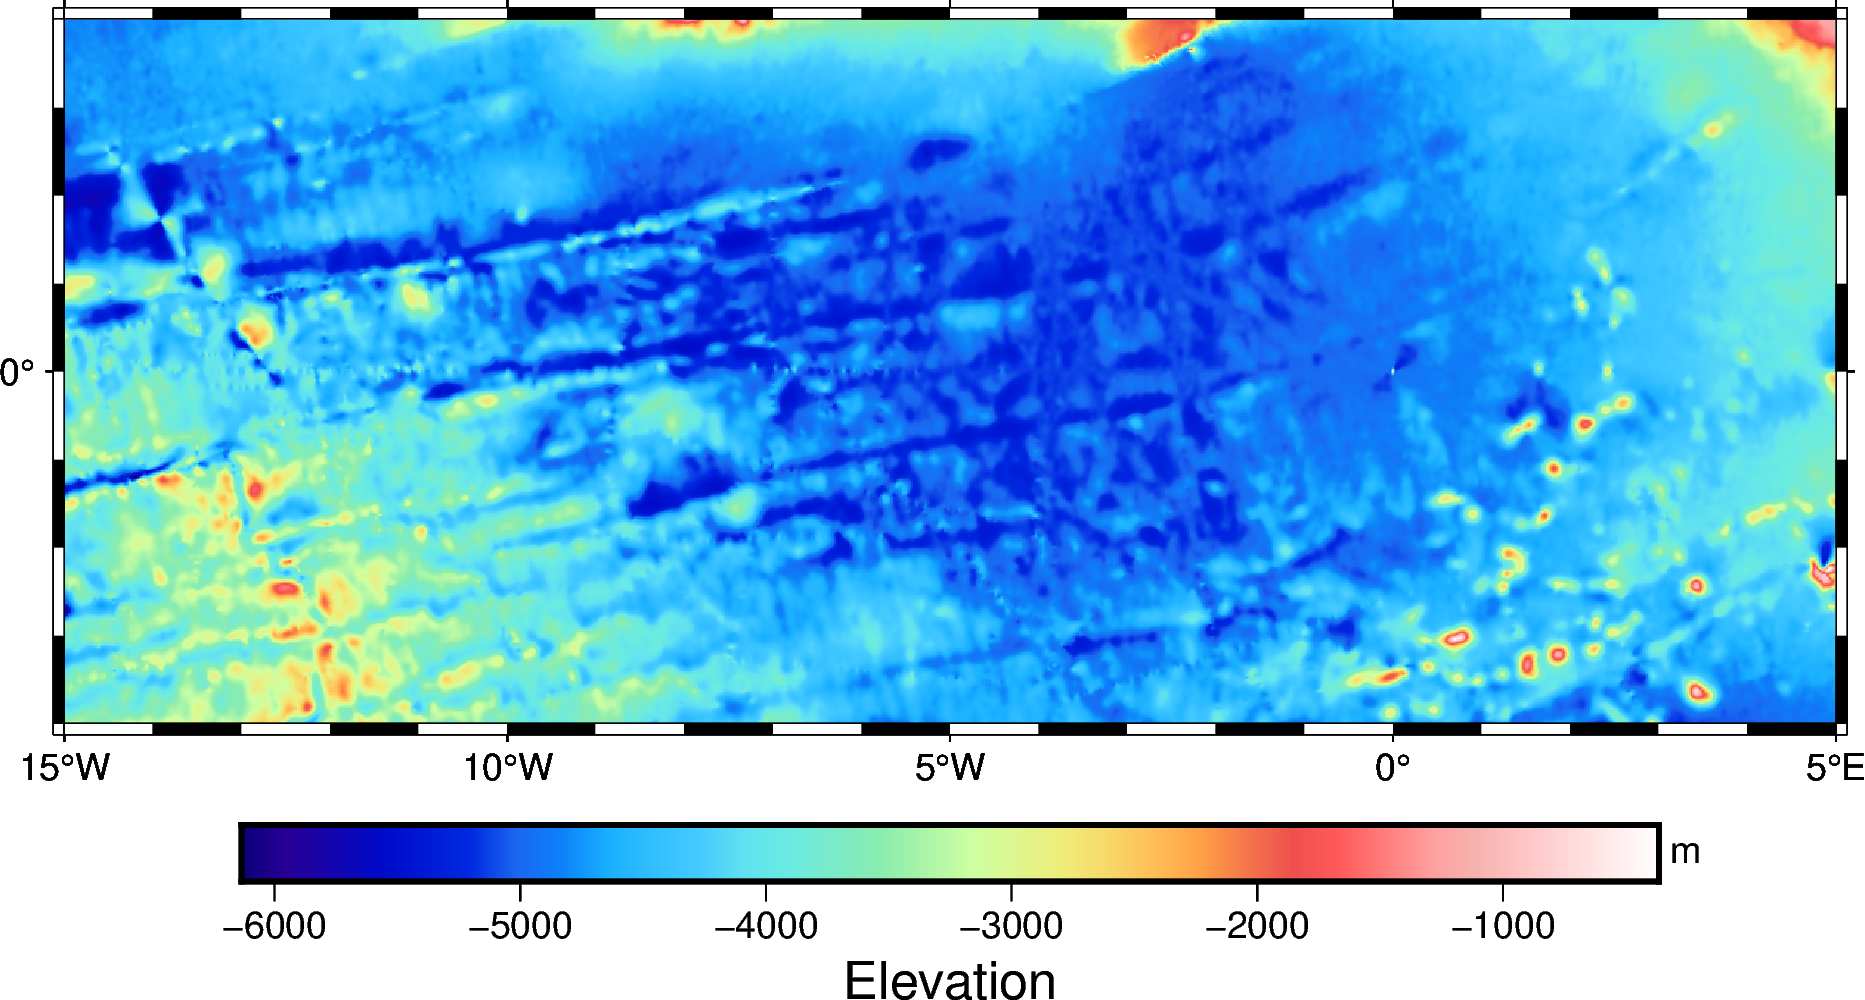

In [233]:
fig = pygmt.Figure()
pygmt.surface(region="-15/5/-4/4", spacing="1m",outgrid="depth_ai1_1.grd",data=depth_ai)
fig.basemap(region="-15/5/-4/4", projection="M15c", frame="afg")
fig.coast(borders=["1/0.5p,black", "2/0.5p,red", "3/0.5p,blue"], land="gray")
fig.grdimage(
    grid="depth_ai1_1.grd",
    cmap="haxby",
    frame=True,
)
fig.colorbar(frame=["a", "x+lElevation", "y+lm"])

fig.show(width="1000")



In [234]:
depth_case = xr.open_dataset("depth_ai1_1.grd")
depth_case.to_netcdf("../result/depth_case3.nc")